# Wikipedia Pipeline: FIGRL test

The dataset used in this experiment can be downloaded through te following link:
http://snap.stanford.edu/jodie/wikipedia.csv

Class Imbalance: 0.05% of all nodes in the dataset are banned

Before the pipeline for the Stanford Wikipedia dataset kicks off, some global parameters need to be defined. We devised a manual
`kfold`-fold out-of-time validation, by dividing the dataset based on a rolling window approach. `timeframe`specifes which timeframe is selected. The `embedding_size`defines the dimension of the embeddings learned by Fast Inductive Graph Representation Learning algorithm. The `intermediate_dimension` is given by choosing an appropriate approximation ratio by the following formula: `intermediate_dimension` = max{4log(amount of nodes)/e^2, k/e^2} with e the approximation ratio and k the final embeddings_size.

In [1]:
# Global parameters:
kfold = 5
timeframe = 2
embedding_size = 10
intermediate_dimension = 100

## 1. Loading the Wikipedia Dataset

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd 
import numpy as np
import time
import dateparser
import networkx as nx
import stellargraph as sg
import scipy
from scipy.sparse import csr
import scipy.sparse

In [3]:
df = pd.read_csv("C:\\Users\\hendr\\OneDrive\\Documents\\KU Leuven Job\\datasets\\reddit.csv",header=None, skiprows=1)
df = df.set_index(df.index+1)

In [4]:
column_name = ['user_id','item_id','timestamp','state_label']
column_name.extend(range(4,176))
df.columns = column_name

In [5]:
df['user_id']+=max(df.index)+1
df['item_id']+=max(df.user_id)+1
print(min(df.item_id))

682448


In [6]:
#def split(x, n): 
#    split_list = []
#    if(x < n):  
#        print(-1) 
#    elif (x % n == 0): 
#        for i in range(n): 
#            split_list.append(x//n) 
#    else: 
#        zp = n - (x % n) 
#        pp = x//n 
#        for i in range(n): 
#            if(i>= zp): 
#                split_list.append(pp + 1) 
#            else: 
#                split_list.append(pp) 
#    return split_list

In [7]:
#split_list = split(672447,kfold)
#split_list
#k = 0
#for i in range(0,kfold):
#    k+=split_list[i]
#    split_list[i]=k

In [8]:
#begin_id = split_list[timeframe-2]
#end_id = split_list[timeframe-1]

In [9]:
#data_timeframe = df.iloc[begin_id:end_id,:]
#cutoff = round(0.6*len(data_timeframe))
#train_data = data_timeframe.head(cutoff)
#inductive_data = data_timeframe.tail(len(data_timeframe)-cutoff)

In [10]:
cutoff = round(0.6*len(df))
train_data = df.head(cutoff)
inductive_data = df.tail(len(df)-cutoff)

In [11]:
print('The distribution of banned pages for the train data is:\n', train_data['state_label'].value_counts())
print('The distribution of banned pages for the inductive data is:\n', inductive_data['state_label'].value_counts())

The distribution of banned pages for the train data is:
 0    403316
1       152
Name: state_label, dtype: int64
The distribution of banned pages for the inductive data is:
 0    268765
1       214
Name: state_label, dtype: int64


### 1.1 Undersampling

In [12]:
undersampling_rate = None

In [13]:
from imblearn.under_sampling import RandomUnderSampler

if not undersampling_rate is None:
    print("An undersampling rate of ", undersampling_rate, "is applied.")
    train_data['index'] = train_data.index
    undersample = RandomUnderSampler(sampling_strategy=(undersampling_rate))
    X, y = undersample.fit_resample(train_data, train_data['state_label'])
    train_data = X.set_index(X['index']).drop('index',axis=1)
    print('The new distribution for the train set is:\n', train_data["state_label"].value_counts())

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


An undersampling rate of  0.1 is applied.
The new distribution for the train set is:
 0    1520
1     152
Name: state_label, dtype: int64


## 2. Construct the Graph Network

A networkx graph is constructed with edit, user and webpage nodes. Creating a three partite graph. The FI-GRL framework derives embeddings starting from an adjacency matrix that it constructs using the graph's edgelist. 

In [14]:
nodes = {"edit":train_data.index, "user":train_data.user_id, "webpage":train_data.item_id}
edges = [zip(train_data.user_id, train_data.index),zip(train_data.item_id, train_data.index)]
g_nx = nx.Graph()
for key, values in nodes.items():
            g_nx.add_nodes_from(values, ntype=key)
for edge in edges:
            g_nx.add_edges_from(edge)

pd.options.mode.chained_assignment = None

train_data['index'] = train_data.index
inductive_data['index'] = inductive_data.index
inductive_graph_data = pd.concat((train_data,inductive_data))
inductive_graph_data = inductive_graph_data.set_index(inductive_graph_data['index']).drop("index",axis = 1)

## 3. Train FIGRL

We want to keep the original indices after concatenating the train and inductive data, because they represent the transaction node ids. We need to concatenate these dataframes in order to easily construct the new graph.

In [15]:
pd.options.mode.chained_assignment = None

train_data['index'] = train_data.index
inductive_data['index'] = inductive_data.index
inductive_graph_data = pd.concat((train_data,inductive_data))
inductive_graph_data = inductive_graph_data.set_index(inductive_graph_data['index']).drop("index",axis = 1)

FI-GRL, a fast inductive graph representation framework is trained using the aforeconstructed graph. This algorithm is implemented in matlab so we make use of matlab.engine to deploy its native implementation. First, we instantiate the FI-GRL class with the intermediate dimension of the matrix between the input graph and the embedding space, in addition to the size of final dimension (embedding space). FI-GRL's train step returns three matrices: U, which represents the embedding space, sigma and v, which are matrices that will be used in the inductive step to generate embeddings for unseen nodes. 

In [16]:
A = nx.adjacency_matrix(g_nx)
print(A.shape)

(3453, 3453)


In [17]:
t0 = time.time()
n,m = A.shape
diags = A.sum(axis=1).flatten()
D = scipy.sparse.spdiags(diags, [0], n, n, format='csr')
#L = D - A
with scipy.errstate(divide='ignore'):
   diags_sqrt = 1.0/np.lib.scimath.sqrt(diags)
diags_sqrt[np.isinf(diags_sqrt)] = 0
DH = scipy.sparse.spdiags(diags_sqrt, [0], n, n, format='csr')

Normalized_random_walk = DH.dot(A.dot(DH))

S = np.random.randn(n, intermediate_dimension) / np.sqrt(intermediate_dimension)

#S = np.array(pd.read_csv('S_train_matrix.csv', header=None))

C = Normalized_random_walk.dot(S)

np.savetxt("S_train_matrix.csv", S, delimiter=",")

from scipy import sparse
sC = sparse.csr_matrix(C)

U, sigma, V = scipy.sparse.linalg.svds(sC, k=embedding_size, tol=0,which='LM')
V = V.transpose()
sigma = np.diag(sigma)

t1 = time.time()
print(t1-t0)

0.6857702732086182


#### Save embeddings

In [18]:
figrl_train_emb = pd.DataFrame(U)
figrl_train_emb = figrl_train_emb.set_index(figrl_train_emb.index)
figrl_train_emb = figrl_train_emb.loc[train_data.index]
sigma = np.array(sigma)
V = np.array(V)
S = np.array(S)

## 4. Inductive Step

In [19]:
nodes = {"edit":inductive_graph_data.index, "user":inductive_graph_data.user_id, "webpage":inductive_graph_data.item_id}
edges = [zip(inductive_graph_data.user_id, inductive_graph_data.index),zip(inductive_graph_data.item_id, inductive_graph_data.index)]
graph_full = nx.Graph()

for key, values in nodes.items():
            graph_full.add_nodes_from(values, ntype=key)
for edge in edges:
            graph_full.add_edges_from(edge)

#### New inductive S

In [20]:
S = np.random.randn(max(inductive_graph_data.item_id)+1, intermediate_dimension) / np.sqrt(intermediate_dimension)

In [21]:
import collections

inductive_dict = {}
for node in inductive_data.index:
    user = inductive_data.loc[node].user_id
    item = inductive_data.loc[node].item_id
    inductive_dict[node] = [user,item]
inductive_dict = collections.OrderedDict(sorted(inductive_dict.items()))

In [22]:
degrees = nx.degree(graph_full)
train_degrees = dict(degrees)
train_degrees = collections.OrderedDict(sorted(train_degrees.items()))

In [23]:
from scipy.sparse import coo_matrix
def get_vector(inductive_dict, max_id):
    print("creating sparse vector matrix")
    row  = []
    col  = []
    data = []
    i = 0
    for node, v in inductive_dict.items():
        for n in v:
            if n is not None:
                row.append(i)
                col.append(n)
                if n > max_id:
                    max_id = int(n)
                #calculate value
                inductive_degree = len([x for x in v if x != None])
                value = 1/np.sqrt(inductive_degree)
                value = value * (1/np.sqrt(train_degrees[n]))
                data.append(value)
        i+=1
    row = np.array(row)
    col = np.array(col)
    data = np.array(data)
    return coo_matrix((data, (row, col)), shape=(len(inductive_dict), max_id+1))

In [24]:
t0 = time.time()
v = get_vector(inductive_dict, max(inductive_graph_data.item_id))
t1 = time.time()
print(t1-t0)

creating sparse vector matrix
2.5902349948883057


In [25]:
import scipy.sparse

t0 = time.time()
inductive_degrees = []

#altijd 2 (onderstaand)
for l in inductive_dict.values():
    x = 0
    for i in l:
        if i is not None:
            x+=1
    inductive_degrees.append(x)
    
def sqrt_d_inv(inductive_degrees):
        sqrt_d_inv = np.array([1/np.sqrt(degree)  if degree > 0 else 0 for degree in inductive_degrees])
        return scipy.sparse.spdiags(sqrt_d_inv,0, sqrt_d_inv.size, sqrt_d_inv.size)
sqrt_d_inv = sqrt_d_inv(inductive_degrees)
t1 = time.time()
print(t1-t0)

0.53562331199646


In [26]:
t0 = time.time()
p = v.dot(S)
U =(p.dot(V)).dot(np.linalg.inv(sigma))
U = sqrt_d_inv.dot(U)
t1 = time.time()

print(t1-t0)

1.403291940689087


In [27]:
figrl_inductive_emb = pd.DataFrame(U, index=inductive_data.index)

## 5. Evaluation

In [28]:
from xgboost import XGBClassifier
classifier = XGBClassifier(n_estimators=100)

In [29]:
train_labels = train_data['state_label']
figrl_train_emb = pd.merge(figrl_train_emb, train_data.loc[figrl_train_emb.index].drop('state_label', axis=1), left_index=True, right_index=True)
figrl_inductive_emb = pd.merge(figrl_inductive_emb, inductive_data.loc[figrl_inductive_emb.index].drop('state_label', axis=1), left_index=True, right_index=True)

baseline_train = train_data.drop('state_label', axis=1)
baseline_inductive = inductive_data.drop('state_label', axis=1)

classifier.fit(baseline_train, train_labels)
baseline_predictions = classifier.predict_proba(baseline_inductive)
    
classifier.fit(figrl_train_emb, train_labels)
predictions = classifier.predict_proba(figrl_inductive_emb)


In [30]:
import scikitplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from matplotlib import pyplot

def pr_curve(probabilities, labels, name):

        """
        This function plots the precision recall curve for the used classification model and a majority classifier.
        
        """
        probs = probabilities[:, 1]
        precision, recall, _ = precision_recall_curve(labels, probs)
        pyplot.plot(recall, precision, label=name)
        # axis labels
        pyplot.xlabel('Recall')
        pyplot.ylabel('Precision')
        # show the legend
        pyplot.legend()
        
        print('Average precision-recall score for ', name, ' configuration XGBoost: {0:0.10f}'.format(average_precision_score(labels, probs)))

Average precision-recall score for  FI-GRL  configuration XGBoost: 0.0015730254
Average precision-recall score for  Baseline  configuration XGBoost: 0.0015730254


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


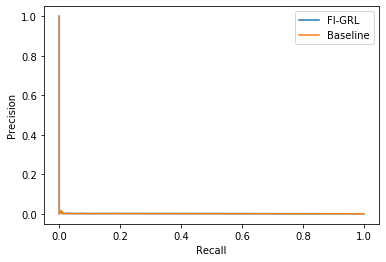

In [31]:
inductive_labels = df.loc[figrl_inductive_emb.index]['state_label']

pr_curve(predictions, inductive_labels, "FI-GRL")

pr_curve(baseline_predictions, inductive_labels, "Baseline")